# Synergy Evaluation

In this notebook, we will evluate the LatteReview package by applying a TitleAbstractReview workflow to some of the systematic review datasets collected in the [ynergy dataset](https://github.com/asreview/synergy-dataset) and in this [article](https://systematicreviewsjournal.biomedcentral.com/articles/10.1186/s13643-024-02575-4/tables/1).

## Setting up the notebook

High-level configs

In [1]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv

# Load environment variables from .env file. Adjust the path to the .env file as needed.
load_dotenv(dotenv_path='../.env')

# Enable asyncio in Jupyter
import asyncio
import nest_asyncio

nest_asyncio.apply()

#  Add the package to the path (required if you are running this notebook from the examples folder)
import sys
sys.path.append('../../')


Import required packages

In [3]:
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import pandas as pd 
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from synergy_dataset import Dataset, iter_datasets
import time

from lattereview.providers import LiteLLMProvider
from lattereview.agents import TitleAbstractReviewer
from lattereview.workflows import ReviewWorkflow

## Data

We will first collect the inclusion and exclusion criteria for six sample systematic reviews from the Synergy dataset. The original inclusion and exclusion criteria are available [here]("https://static-content.springer.com/esm/art%3A10.1186%2Fs13643-024-02575-4/MediaObjects/13643_2024_2575_MOESM2_ESM.docx").

In [4]:
search_criteria_dict = {
    "Appenzeller-Herzog_2019": {
        "inclusion_criteria": "-Patients with Wilson's Disease of any age or stage\n-Study drug has to be one of four established therapies, namely DPen, trientine, TTM or Zn.\n-Control could be placebo, no treatment or any other treatment that does not include the respective study drug\n-Concomitant therapies had to be identical in the compared treatment arms\n-Combination therapy regimens that include the respective monotherapy drug are not considered\n-Prospective or retrospective studies reported\n-Randomized, non-randomized controlled trials and comparative observational studies",
        "exclusion_criteria": "-Animal studies, case reports, case series, cross-sectional studies, before-after studies, reviews, letters, abstract-only publications, editorials, diagnostic or other testing studies and non-controlled studies"
    },
    "Donners_2021": {
        "inclusion_criteria": "The following inclusion criteria are applied: emicizumab studies providing (1) data on humans, (2) original PK data or modeled PK data or PK/PD relationships, and (3) access to the abstract and the full text in English. In the event of doubt regarding eligibility, the records or articles should be included.",
        "exclusion_criteria": "Not specified"
    },
    "Jeyaraman_2020": {
        "inclusion_criteria": "Studies are included if they meet the following PICOS criteria: Population: Patients with knee osteoarthritis Intervention: MSC therapy Comparator: Usual care Outcomes: Visual Analog Score (VAS) for Pain, Western Ontario McMaster Universities Osteoarthritis Index (WOMAC), Lysholm Knee Scale (Lysholm), Whole-Organ Magnetic Resonance Imaging Score (WORMS), Knee Osteoarthritis Outcome Score (KOOS), and adverse events Study Design: Randomized controlled trials",
        "exclusion_criteria": "Trials are excluded if they had the following characteristics: 1. Observational studies and interventional studies without a comparator group 2. Animal studies involving stem cell therapy for knee osteoarthritis models 3. Review"
    },
    "Meijboom_2021": {
        "inclusion_criteria": "Articles are included if they meet the following criteria: (1) study involved transitioning from a TNF-alpha inhibitor (including etanercept, infliximab, and adalimumab) originator to a biosimilar, (2) the number of patients who retransitioned is reported or can be calculated, (3) the article is an original research article published in a peer-reviewed journal, (4) the article included baseline characteristics of the patients who transitioned, (5) the article is written in English. Transitioning is defined as patients in whom the biosimilar was introduced after the originator, without treatment with other drugs in between. Retransitioning is defined as restarting the originator directly after discontinuing a biosimilar, without treatment with other drugs in between. In summary, transitioning is defined as switching from the originator to a biosimilar; retransitioning is defined as switching from the originator to a biosimilar and back to the originator. Both transitioning and retransitioning involve changes with the same active biological substance.",
        "exclusion_criteria": "Not specified"
    },
    "Muthu_2021": {
        "inclusion_criteria": "To be included, a study should meet the following criteria: 1. The study should be an RCT with 1:1 parallel two-arm design. 2. The study must be related to spine surgery involving preoperative or intraoperative or postoperative variables. 3. The study must have a dichotomous primary or secondary outcome.",
        "exclusion_criteria": "1. Studies not involving human subjects. 2. Studies with continuous variable outcomes like pain scores, Oswestry Disability Index scores, time to union without predefined clinical success criteria. 3. Studies that did not report a statistically significant primary or secondary outcome measure."
    },
    "Oud_2018": {
        "inclusion_criteria": "Randomized controlled trials (RCT)s on four specialized psychotherapies (DBT: dialectic behavior therapy, MBT: mentalization-based treatment, TFP: transference-focused therapy and ST: schema therapy) for adults (18 years and older) with Borderline personality disorder (BPD), which includes an individual psychotherapy component and had a duration of 16 weeks or more. Eligible comparison groups are other protocolized and specialized psychotherapies, or control groups, for example, treatment as usual (TAU), waiting list, attention control or community treatment by experts (CTBE).",
        "exclusion_criteria": "Studies are excluded with a cut-off of <66% of the participants having BPD, unless disaggregated data are provided. Studies are excluded that tested incomplete versions of specialized treatment, for example, studies that investigated only skills training instead of the full DBT program."
    }
}



# Make all keys lowercase
search_criteria_dict = {k.lower(): v for k, v in search_criteria_dict.items()}


Now let's download the dataset for each of the systematic reviews above, and save them as a local pickled file.

In [5]:
all_review_jobs = [(d.name, d.to_frame()) for d in iter_datasets() if isinstance(d.to_frame(), pd.DataFrame) and d.name.lower() in search_criteria_dict]

# Print the number of review items in each study
for df_name, df in all_review_jobs:
    print(f"{df_name}: {len(df)} items")

# Save the dictionary as a pickle file for easier reference
with open('synergy_data/all_review_jobs.pickle', 'wb') as f:
    pickle.dump(all_review_jobs, f)


Appenzeller-Herzog_2019: 2873 items
Donners_2021: 258 items
Jeyaraman_2020: 1175 items
Meijboom_2021: 882 items
Muthu_2021: 2719 items
Oud_2018: 952 items


## Review

Now let's define two imaginary junior (cheap model) and one senior (expensive model) reviewer agents that all belong to the TitleAbstractReviewer class.

In [11]:
# Load back the data

with open('synergy_data/all_review_jobs.pickle', 'rb') as f:
    all_review_jobs = pickle.load(f)

In [12]:
def create_reviewers(inclusion_criteria, exclusion_criteria):

    inclusion_criteria = str(inclusion_criteria)
    exclusion_criteria = str(exclusion_criteria)

    Agent1 = TitleAbstractReviewer(
        provider=LiteLLMProvider(model="gemini/gemini-1.5-flash"),
        name="Agent1",
        backstory="a PhD researcher",
        inclusion_criteria = inclusion_criteria,
        exclusion_criteria = exclusion_criteria,        
        max_concurrent_requests=30, 
        model_args={"max_tokens": 200, "temperature": 0.1},
    )

    Agent2 = TitleAbstractReviewer(
        provider=LiteLLMProvider(model="gpt-4o-mini"),
        name="Agent2",
        backstory="a PhD researcher",
        inclusion_criteria = inclusion_criteria,
        exclusion_criteria = exclusion_criteria,        
        max_concurrent_requests=30, 
        model_args={"max_tokens": 200, "temperature": 0.1},
    )

    Agent3 = TitleAbstractReviewer(
        provider=LiteLLMProvider(model="gpt-4o"),
        name="Agent3",
        backstory="a senior PhD researcher with years of experience in conducting systematic reviews",
        inclusion_criteria = inclusion_criteria,
        exclusion_criteria = exclusion_criteria,        
        max_concurrent_requests=30, 
        model_args={"max_tokens": 200, "temperature": 0.1},
        additional_context="""
        Two PhD reviewers have already reviwed this article and disagree on how to evaluate it. You can read their evaluation above.
        """
    )

    return Agent1, Agent2, Agent3

The next step is coming up with a review workflow that can apply these reviewers to the datasets above. We will apply this workflow to the batches of 1000 title-abstract pair from all datsets.
The reason for batching is to not hit the limitation of OpenAI and Gemini providers.

In [13]:
def split_dataframe(df, chunk_size):
    """Splits a DataFrame into smaller DataFrames of a specified chunk size."""
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

async def process_sub_df(sub_df, review_job, inclusion_criteria, exclusion_criteria):
    """Processes a single sub DataFrame."""
    Agent1, Agent2, Agent3 = create_reviewers(inclusion_criteria, exclusion_criteria)

    def filter_func(row):
        score1 = int(row["round-A_Agent1_output"]["evaluation"])
        score2 = int(row["round-A_Agent2_output"]["evaluation"])
        if score1 != score2:
            if score1 >= 4 and score2 >= 4:
                return False
            if score1 >= 3 or score2 >= 3:
                return True
        elif score1 == score2 == 3:
            return True
        return False

    title_abs_review = ReviewWorkflow(
        workflow_schema=[
            {
                "round": 'A',
                "reviewers": [Agent1, Agent2],
                "text_inputs": ["title", "abstract"]
            },
            {
                "round": 'B',
                "reviewers": [Agent3],
                "text_inputs": ["title", "abstract", "round-A_Agent1_output", "round-A_Agent2_output"],
                "filter": filter_func
            }
        ]
    )

    updated_df = await title_abs_review(sub_df)
    costs = title_abs_review.get_total_cost()
    return updated_df, costs

async def review(review_job, sample_size=None):
    inclusion_criteria = search_criteria_dict[review_job[0].lower()]["inclusion_criteria"]
    exclusion_criteria = search_criteria_dict[review_job[0].lower()]["exclusion_criteria"]
    df = review_job[1]

    if sample_size:
        df = df.sample(sample_size)

    # Split the DataFrame into sub-DataFrames of size 1000 or less
    sub_dfs = split_dataframe(df, 1000)

    results = []
    total_cost = 0

    for n, sub_df in enumerate(sub_dfs):
        updated_sub_df, sub_cost = await process_sub_df(sub_df, review_job, inclusion_criteria, exclusion_criteria)
        results.append(updated_sub_df)
        total_cost += sub_cost
        if n < len(sub_dfs) - 1:
            print(f"\n====== Finished reviewing {review_job[0]} ({(n + 1) * 1000}/{len(df)}) ======\n")
            print(f"\nTotal cost: {total_cost}")
            print("-" * 50)
            time.sleep(60)  # Wait for 1 minute between processing each sub-DataFrame

    # Concatenate all the updated sub-DataFrames into a unified DataFrame
    unified_df = pd.concat(results)

    # Save the results
    unified_df.to_csv(f"synergy_data/{review_job[0]}_reviewed.csv")

    # Print the costs
    print(f"\n====== Finished reviewing {review_job[0]} ======\n")
    print(f"\nTotal cost: {total_cost}")
    print("-" * 100)

    return unified_df, total_cost

Now, we will actually run the workflow for each dataset.

In [19]:
# Reviewing Appenzeller-Herzog_2019
review_job = [j for j in all_review_jobs if j[0] == "Appenzeller-Herzog_2019"][0]
_ = asyncio.run(review(review_job))


====== Starting review round A (1/2) ======

Processing 1000 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:16:32: 100%|██████████| 1000/1000 [00:19<00:00, 52.36it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:16:51: 100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 122 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:17:29: 100%|██████████| 122/122 [00:07<00:00, 17.20it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Appenzeller-Herzog_2019 (1000/2873) ======


Total cost: 0.002158025
--------------------------------------------------

====== Starting review round A (1/2) ======

Processing 1000 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:18:36: 100%|██████████| 1000/1000 [00:18<00:00, 52.89it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:18:55: 100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 123 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:19:32: 100%|██████████| 123/123 [00:07<00:00, 16.25it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Appenzeller-Herzog_2019 (2000/2873) ======


Total cost: 0.005445125
--------------------------------------------------

====== Starting review round A (1/2) ======

Processing 873 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:20:40: 100%|██████████| 873/873 [00:16<00:00, 53.02it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:20:57: 100%|██████████| 873/873 [00:33<00:00, 25.77it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 90 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:21:30: 100%|██████████| 90/90 [00:05<00:00, 15.63it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Appenzeller-Herzog_2019 ======


Total cost: 0.007809775
----------------------------------------------------------------------------------------------------


In [14]:
# Reviewing Donners_2021
review_job = [j for j in all_review_jobs if j[0] == "Donners_2021"][0]
_ = asyncio.run(review(review_job))


====== Starting review round A (1/2) ======

Processing 258 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:03:02: 100%|██████████| 258/258 [00:06<00:00, 41.51it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:03:09: 100%|██████████| 258/258 [00:11<00:00, 21.83it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 60 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:03:21: 100%|██████████| 60/60 [00:03<00:00, 15.48it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Donners_2021 ======


Total cost: 0.00241135
----------------------------------------------------------------------------------------------------


In [15]:
# Reviewing Jeyaraman_2020
review_job = [j for j in all_review_jobs if j[0] == "Jeyaraman_2020"][0]
_ = asyncio.run(review(review_job))


====== Starting review round A (1/2) ======

Processing 1000 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:03:30: 100%|██████████| 1000/1000 [00:20<00:00, 48.76it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:03:50: 100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 19 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:04:29: 100%|██████████| 19/19 [00:04<00:00,  4.39it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Jeyaraman_2020 (1000/1175) ======


Total cost: 0.0034937
--------------------------------------------------

====== Starting review round A (1/2) ======

Processing 175 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:05:33: 100%|██████████| 175/175 [00:03<00:00, 44.32it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:05:37: 100%|██████████| 175/175 [00:09<00:00, 17.88it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 2 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:05:47: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Jeyaraman_2020 ======


Total cost: 0.007337000000000001
----------------------------------------------------------------------------------------------------


In [16]:
# Reviewing Meijboom_2021
review_job = [j for j in all_review_jobs if j[0] == "Meijboom_2021"][0]
_ = asyncio.run(review(review_job))


====== Starting review round A (1/2) ======

Processing 882 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:06:19: 100%|██████████| 882/882 [00:19<00:00, 46.38it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:06:38: 100%|██████████| 882/882 [00:39<00:00, 22.12it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 89 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:07:18: 100%|██████████| 89/89 [00:26<00:00,  3.32it/s]

The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Meijboom_2021 ======


Total cost: 0.0038126000000000006
----------------------------------------------------------------------------------------------------


In [18]:
# Reviewing Muthu_2021
review_job = [j for j in all_review_jobs if j[0] == "Muthu_2021"][0]
_ = asyncio.run(review(review_job))


====== Starting review round A (1/2) ======

Processing 1000 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:09:38: 100%|██████████| 1000/1000 [00:22<00:00, 44.72it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:10:01:  83%|████████▎ | 834/1000 [00:32<00:07, 21.77it/s]

Error reviewing item: Error getting JSON response: Error fetching response: litellm.JSONSchemaValidationError: model=, returned an invalid response={"reasoning":"The study is a prospective randomized controlled trial (RCT) with a 1:1 parallel two-arm design, focuses on spine surgery for isthmic spondylolisthesis, and reports dichotomous outcomes (fusion rates), thus meeting all inclusion criteria and none of the, for schema={"reasoning":"The study is a prospective randomized controlled trial (RCT) with a 1:1 parallel two-arm design, focuses on spine surgery for isthmic spondylolisthesis, and reports dichotomous outcomes (fusion rates), thus meeting all inclusion criteria and none of the.
Access raw response with `e.raw_response`. Retrying 0/3


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:10:01: 100%|██████████| 1000/1000 [00:43<00:00, 22.76it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 207 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:10:45: 100%|██████████| 207/207 [00:12<00:00, 16.57it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Muthu_2021 (1000/2719) ======


Total cost: 0.003485825
--------------------------------------------------

====== Starting review round A (1/2) ======

Processing 1000 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:11:57: 100%|██████████| 1000/1000 [00:22<00:00, 43.60it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:12:20: 100%|██████████| 1000/1000 [00:40<00:00, 24.86it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 224 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:13:00: 100%|██████████| 224/224 [00:11<00:00, 19.01it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Muthu_2021 (2000/2719) ======


Total cost: 0.007030275000000001
--------------------------------------------------

====== Starting review round A (1/2) ======

Processing 719 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:14:12: 100%|██████████| 719/719 [00:16<00:00, 44.48it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:14:28: 100%|██████████| 719/719 [00:31<00:00, 23.08it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 165 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:15:00: 100%|██████████| 165/165 [00:09<00:00, 16.75it/s]


The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Muthu_2021 ======


Total cost: 0.010329050000000001
----------------------------------------------------------------------------------------------------


In [17]:
# Reviewing Oud_2018
review_job = [j for j in all_review_jobs if j[0] == "Oud_2018"][0]
_ = asyncio.run(review(review_job))


====== Starting review round A (1/2) ======

Processing 952 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 19:08:08: 100%|██████████| 952/952 [00:21<00:00, 45.30it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 19:08:29: 100%|██████████| 952/952 [00:38<00:00, 24.94it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 126 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:09:08: 100%|██████████| 126/126 [00:10<00:00, 12.10it/s]

The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['doi', 'title', 'abstract', 'label_included', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing Oud_2018 ======


Total cost: 0.003134675
----------------------------------------------------------------------------------------------------


## Statistics

Finally, it's time to calculate some statistical metrics to report the performance of the review workflow on different datasets.
As a `TitleAbstractReviewer` returns a score between 1 to 5, we can set different thresholds for inclusion of articles, and therefore report the workflow performance in three different sensetive, specific, and balanced modes.

In [6]:
def get_score(row):
    if "round-B_Agent3_output" in row and not pd.isna(row["round-B_Agent3_evaluation"]):
        return int(row["round-B_Agent3_evaluation"])
    score1 = int(row["round-A_Agent1_evaluation"])
    score2 = int(row["round-A_Agent2_evaluation"])
    return (score1 + score2)/2
    
raw_data = dict()

all_csv_files = glob.glob("synergy_data/*_reviewed.csv")
for csv_file in all_csv_files:
    df = pd.read_csv(csv_file)
    review_name = csv_file.split("/")[-1].split("_reviewed.csv")[0]
    labels = df["label_included"].apply(lambda x: int(x)).tolist()
    scores = df.apply(get_score, axis=1).tolist()
    raw_data[review_name] = (labels, scores)

raw_data.keys()

dict_keys(['Oud_2018', 'Appenzeller-Herzog_2019', 'Muthu_2021', 'Meijboom_2021', 'Jeyaraman_2020', 'Donners_2021'])

In [7]:
def evaluate_metrics(ground_truth, predictions, threshold_sensitive, threshold_specific, threshold_balanced):
    def classify(pred, threshold):
        return [1 if p >= threshold else 0 for p in pred]

    # Assert all ground truth values are either 0 or 1
    assert all([g in [0, 1] for g in ground_truth])

    num_articles = len(ground_truth)
    percentage_relevant = sum(ground_truth) / len(ground_truth) * 100

    thresholds = [threshold_sensitive, threshold_specific, threshold_balanced]
    metrics = {}
    for label, threshold in zip(['sensitive', 'specific', 'balanced'], thresholds):
        percentage_predicted = len([p for p in predictions if p >= threshold]) / len(predictions) * 100
        pred = classify(predictions, threshold)

        tn, fp, fn, tp = confusion_matrix(ground_truth, pred, labels=[0, 1]).ravel()
        metrics[f'accuracy_{label}'] = accuracy_score(ground_truth, pred)
        metrics[f'precision_{label}'] = precision_score(ground_truth, pred, zero_division=0)
        metrics[f'recall_{label}'] = recall_score(ground_truth, pred, zero_division=0)
        metrics[f'specificity_{label}'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics[f'percentage_predicted_{label}'] = percentage_predicted

    # Check for valid AUC calculation
    metrics['auc'] = roc_auc_score(ground_truth, predictions) if len(set(ground_truth)) > 1 else float('nan')

    return {
        'num_articles': num_articles,
        'percentage_relevant': percentage_relevant,
        **metrics
    }

# Updated thresholds
threshold_sensitive = 1.5 # Score >= 1.5
threshold_balanced = 3  # Score > 3.0
threshold_specific = 4.5  # Score >= 4.5

# Collect data for plotting
roc_curves = {}
sensitivity_specificity_points = []
rows = []
colors = cm.tab10.colors  # Use distinct colors for each dataset

for i, (dataset_name, (ground_truth, predictions)) in enumerate(raw_data.items()):
    metrics = evaluate_metrics(ground_truth, predictions, threshold_sensitive, threshold_specific, threshold_balanced)
    sensitivity_specificity_points.append((
        dataset_name, 
        metrics['recall_sensitive'], metrics['specificity_sensitive'], 
        metrics['recall_specific'], metrics['specificity_specific'], 
        metrics['recall_balanced'], metrics['specificity_balanced'], 
        colors[i % len(colors)]
    ))

    if len(set(ground_truth)) > 1:
        fpr, tpr, _ = roc_curve(ground_truth, predictions)
        roc_curves[dataset_name] = (fpr, tpr, colors[i % len(colors)])

    rows.append({
        'Dataset': dataset_name,
        'Number of Articles': metrics['num_articles'],
        '% Relevant': metrics['percentage_relevant'],
        '% Predicted (Sensitive)': metrics['percentage_predicted_sensitive'],
        'Accuracy (Sensitive)': metrics['accuracy_sensitive'],
        'Precision (Sensitive)': metrics['precision_sensitive'],
        'Recall (Sensitive)': metrics['recall_sensitive'],
        '% Predicted (Specific)': metrics['percentage_predicted_specific'],
        'Accuracy (Specific)': metrics['accuracy_specific'],
        'Precision (Specific)': metrics['precision_specific'],
        'Recall (Specific)': metrics['recall_specific'],
        '% Predicted (Balanced)': metrics['percentage_predicted_balanced'],
        'Accuracy (Balanced)': metrics['accuracy_balanced'],
        'Precision (Balanced)': metrics['precision_balanced'],
        'Recall (Balanced)': metrics['recall_balanced'],
        'AUC': metrics['auc']
    })

# Create a DataFrame for the results
output_df = pd.DataFrame(rows)
output_df = output_df.round(2)

# Display the DataFrame
output_df

,Dataset,Number of Articles,% Relevant,% Predicted (Sensitive),Accuracy (Sensitive),Precision (Sensitive),Recall (Sensitive),% Predicted (Specific),Accuracy (Specific),Precision (Specific),Recall (Specific),% Predicted (Balanced),Accuracy (Balanced),Precision (Balanced),Recall (Balanced),AUC
0,Oud_2018,952,2.10,38.87,0.63,0.05,1.00,3.78,0.96,0.28,0.50,8.09,0.93,0.21,0.80,0.95
1,Appenzeller-Herzog_2019,2873,0.90,28.68,0.72,0.03,0.85,1.74,0.98,0.12,0.23,3.72,0.96,0.07,0.31,0.85
2,Muthu_2021,2719,12.36,68.96,0.42,0.17,0.96,8.31,0.84,0.27,0.18,10.48,0.83,0.28,0.24,0.73
3,Meijboom_2021,882,4.20,59.41,0.45,0.07,0.97,13.49,0.89,0.26,0.84,14.40,0.88,0.24,0.84,0.90
4,Jeyaraman_2020,1175,8.17,15.32,0.85,0.27,0.50,0.26,0.92,0.67,0.02,0.26,0.92,0.67,0.02,0.71
5,Donners_2021,258,5.81,93.02,0.13,0.06,1.00,29.46,0.72,0.13,0.67,34.50,0.68,0.12,0.73,0.77


We can also plot the performance in all three modes. Obviously, the ROC curves are threshold-agnostic and we will have one single curve for each datasets.

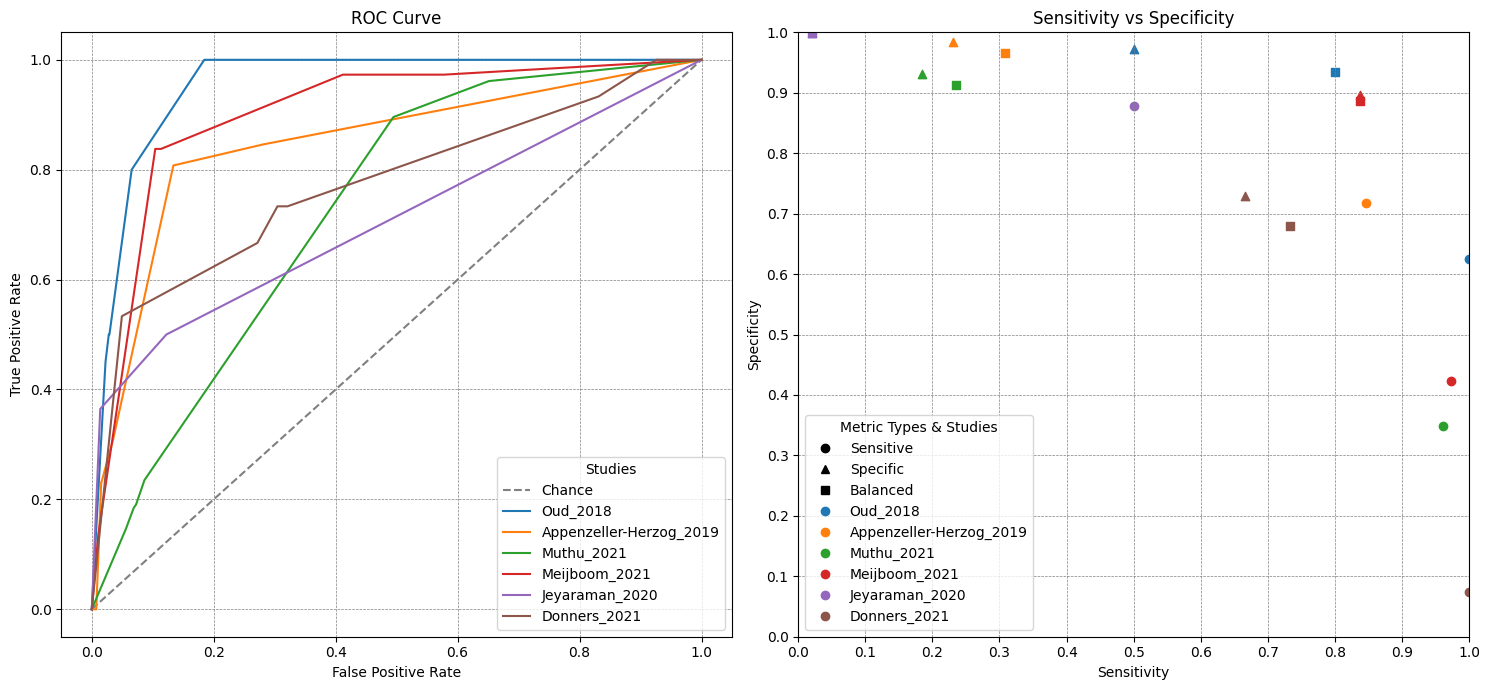

In [53]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: ROC Curve
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
for dataset_name, (fpr, tpr, color) in roc_curves.items():
    axes[0].plot(fpr, tpr, label=dataset_name, color=color)
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(title="Studies", loc='lower right')  # Show studies' color codes in the ROC plot legend

# Add horizontal and vertical grid lines
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Plot 2: Sensitivity vs Specificity
for dataset_name, sens_sen, spec_sen, sens_spec, spec_spec, sens_bal, spec_bal, color in sensitivity_specificity_points:
    axes[1].scatter(sens_sen, spec_sen, marker='o', color=color)
    axes[1].scatter(sens_spec, spec_spec, marker='^', color=color)
    axes[1].scatter(sens_bal, spec_bal, marker='s', color=color)
axes[1].set_title("Sensitivity vs Specificity")
axes[1].set_xlabel("Sensitivity")
axes[1].set_ylabel("Specificity")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_xticks([i * 0.1 for i in range(11)])
axes[1].set_yticks([i * 0.1 for i in range(11)])

# Add horizontal and vertical grid lines
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Create combined legend entries
legend_elements = [
    Line2D([], [], marker='o', color='black', linestyle='', label='Sensitive'),
    Line2D([], [], marker='^', color='black', linestyle='', label='Specific'),
    Line2D([], [], marker='s', color='black', linestyle='', label='Balanced'),
]

# Add dataset-specific colors to the legend
for dataset_name, *_ , color in sensitivity_specificity_points:
    legend_elements.append(
        Line2D([], [], marker='o', color=color, linestyle='', label=dataset_name)
    )

# Add the combined legend
axes[1].legend(
    handles=legend_elements,
    title="Metric Types & Studies",
    loc='lower left'
)

plt.tight_layout()
plt.show()
